# Seattle flu seq coverage statistics 

January 30, 2019 

Chris just finished another round of sequencing with the new Twist array. 

#### references used
1. A/California/04/2009: I figured that any H1N1s from the past several years should map to CA04. (length = 14,552 - this is too long because my reference includes M1 and M2 separately and NS1 and NS2 separately)
2. A/HongKong/4801/2014: This was used as a recent vaccine strain for H3N2. (length = 13472)
3. B/Michigan/49/2017: This was recently used as a Victoria-like B vaccine strain. (length = 14403)
4. B/Phuket/3073/2013: This was recently used as a Yamagata-like B vaccine strain. (length = 14175)

In [272]:
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import seaborn as sns
%load_ext rpy2.ipython 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [273]:
sf_directory = "/Volumes/gradschool-and-postdoc-backups/post-doc/stored_files_too_big_for_laptop/seattle-flu/2019-01-28/"

## Generate functions for pulling total mapped reads and coverage info

This information is coming from the coverage_stats.txt and log files

#### Write 4 functions: 
1. to gather and plot the total number of reads in the file and the percentage that mapped 
2. to gather coverage for each gene

In [274]:
# make a dataset dictionary to make it easier to run these all through my function
dataset = {}
dataset['ca04_capture'] = {"dir": sf_directory + "mapped-to-A-California-04-2009/", "reference_sequence" : "A/California/04/2009", "method":"capture"}
dataset['hk4801_capture'] = {"dir": sf_directory + "mapped-to-A-HongKong-4801-2014/", "reference_sequence" : "A/HongKong/4801/2014", "method":"capture"}
dataset['BMich_capture'] = {"dir": sf_directory + "mapped-to-B-Michigan-49-2017/", "reference_sequence" : "B/Michigan/49/2017", "method":"capture"}
dataset['BPhuk_capture'] = {"dir": sf_directory + "mapped-to-B-Phuket-3073-2013/", "reference_sequence" : "B/Phuket/3073/2013", "method":"capture"}

In [275]:
# make a dictionary with reference sequence lengths 
ref_seq_lengths = {"A/California/04/2009": 14552, "A/HongKong/4801/2014": 13472, "B/Michigan/49/2017": 14403, "B/Phuket/3073/2013":14175}

## Pull total mapped reads from log file 

In [276]:
# plot total number of reads and mapped percentage using the log files
def get_total_and_mapped_reads(virus_method):

    output_dict = {}
    working_directory = dataset[virus_method]['dir']
    
    for f in glob.glob(working_directory + "*log_file*"):
        with open(f, "r") as infile: 
        
            # pull out sample name
            sample = f.split("/")[8].split("_")[0]
        
            # pull out read data
            for line in infile: 
                if "reads" in line: 
                    total_reads = int(line.split(" ")[0])
                if "aligned exactly 1 time" in line: 
                    aligned_once = int(line.split(" ")[4])
                if "aligned >1 times" in line:
                    aligned_at_least_once = int(line.split(" ")[4])
        
            output_dict[sample] = {}
            output_dict[sample]["total_reads"] = total_reads
            output_dict[sample]["aligned_once"] = aligned_once
            output_dict[sample]["aligned_at_least_once"] = aligned_at_least_once
            output_dict[sample]["total_aligned"] = aligned_once + aligned_at_least_once
            output_dict[sample]["total_percent_aligned"] = (float((aligned_once + aligned_at_least_once))/float(total_reads))*100
            output_dict[sample]["method"] = dataset[virus_method]['method']
            output_dict[sample]["reference_sequence"] = dataset[virus_method]['reference_sequence']
    
    return(output_dict)

In [277]:
# run function on all mappings
ca04_capture_dict = get_total_and_mapped_reads('ca04_capture')
hk4801_capture_dict = get_total_and_mapped_reads('hk4801_capture')
BMich_capture_dict = get_total_and_mapped_reads('BMich_capture')
BPhuk_capture_dict = get_total_and_mapped_reads('BPhuk_capture')

In [278]:
#print(ca04_capture_dict)

## Output the reference to which the largest number of reads mapped

In [279]:
def output_top_reference_sequence(captures):
    
    # convert all dictionaries in both datasets to dataframes
    capture_df = (pd.DataFrame.from_dict(captures[0], orient='index')).append(pd.DataFrame.from_dict(captures[1], orient='index'))
    capture_df = capture_df.append(pd.DataFrame.from_dict(captures[2], orient='index'))
    capture_df = capture_df.append(pd.DataFrame.from_dict(captures[3], orient='index'))
    capture_df.reset_index(inplace=True)
    
    # for each sample, figure out the reference to which the most number of reads mapped; subset and pivot dataframe
    df_capture = capture_df[['index','total_percent_aligned','reference_sequence']]

    df_capture = df_capture.pivot(index='reference_sequence', columns='index', values='total_percent_aligned')
    df_capture.head()
    
    # pull out which reference had the max % of reads mapped to it and add it as a row called "max"
    df1_capture = (df_capture.idxmax(axis=0)).to_frame()
    df1_capture.reset_index(inplace=True)
    df1_capture.columns=['index','max']
    df1_capture.head()

    # save this dataframe as a dictionary so I can use it later 
    top_reference_sequence_match_capture_df = df1_capture.set_index("index")
    top_reference_sequence_match_capture = top_reference_sequence_match_capture_df.transpose().to_dict()
    
    return(top_reference_sequence_match_capture, top_reference_sequence_match_capture_df, capture_df)

In [280]:
# run to output the top reference sequence match for each sample in the dataset
captures = [ca04_capture_dict, hk4801_capture_dict, BMich_capture_dict, BPhuk_capture_dict]

top_reference_sequence_match_capture, top_reference_sequence_match_capture_df, capture_df = output_top_reference_sequence(captures)

In [281]:
# top_reference_sequence_match_capture
capture_df.head()

,index,total_reads,aligned_once,aligned_at_least_once,total_aligned,total_percent_aligned,method,reference_sequence
0,312225,136199,1,0,1,0.000734,capture,A/California/04/2009
1,312226,75446,18809,5325,24134,31.988442,capture,A/California/04/2009
2,312227,1945242,449789,153713,603502,31.024520,capture,A/California/04/2009
3,312228,6622,447,77,524,7.913017,capture,A/California/04/2009
4,312229,228715,0,0,0,0.000000,capture,A/California/04/2009


## Pull mean coverage from coverage stats file

In [282]:
# in a very annoying twist, the names of the references have been cut off of some of the coverage files, so I need 
# to infer which gene is is based on other information. For B-Phuket, each line has a length associated with it,
# which I can use 

A_CA04_ref_lengths_dict = {"gb:FJ969516:1-2280|Organism:Influenza":"PB2", "gb:FJ966080:1-2274|Organism:Influenza":"PB1",
                           "gb:FJ966081:1-2151|Organism:Influenza":"PA", "gb:FJ966083:1-1497|Organism:Influenza":"NP",
                            "gb:FJ966082:1-1701|Organism:Influenza":"HA","gb:FJ966084:1-1410|Organism:Influenza":"NA",
                            "gb:FJ969513:1-759|Organism:Influenza":"M1", "gb:FJ969513:1-982|Organism:Influenza":"M2",
                            "gb:FJ969514:1-660|Organism:Influenza":"NS1", "gb:FJ969514:1-838|Organism:Influenza":"NEP"}

In [283]:
# plot total number of reads and mapped percentage using the log files
def get_mean_coverage_per_gene(virus_method):

    output_dict2 = {}
    working_directory = dataset[virus_method]['dir']
    
    for f in glob.glob(working_directory + "*coverage_stats.txt"):
        with open(f, "r") as infile: 
        
            # pull out sample name
            sample = f.split("/")[8].split("_")[0]
            output_dict2[sample] = {}
            
            reference_sequence = dataset[virus_method]['reference_sequence']
            
            # pull out read data
            for line in infile: 
                if "ref" not in line:
                    if reference_sequence == "A/California/04/2009":
                        gene = A_CA04_ref_lengths_dict[line.split(" ")[0]]
                    else :
                        gene = line.split(" ")[0].split("|")[12].replace("_","")
                    
                    mean_coverage = float(line.split()[2])
                    output_dict2[sample][gene] = mean_coverage
        
            output_dict2[sample]["method"] = dataset[virus_method]['method']
            output_dict2[sample]["reference_sequence"] = reference_sequence
    
    return(output_dict2)
    print(output_dict2)

In [284]:
# pull mean coverage for all datasets
ca04_capture_dict2 = get_mean_coverage_per_gene('ca04_capture')
hk4801_capture_dict_dict2 = get_mean_coverage_per_gene('hk4801_capture')
BMich_capture_dict2 = get_mean_coverage_per_gene('BMich_capture')
BPhuk_capture_dict2 = get_mean_coverage_per_gene('BPhuk_capture')

In [285]:
#ca04_capture_dict2

## Calculate fraction of genome covered  

In [286]:
def calculate_percent_genome_coverage(virus_method):
    
    output_dict3 = {}
    working_directory = dataset[virus_method]['dir']
    reference_seq = dataset[virus_method]["reference_sequence"]

    for f in glob.glob(working_directory + "*.sam.sorted.bam.pileup"):
        with open(f, "r") as infile: 
        
            # pull out sample name
            sample = f.split("/")[8].split("_")[0]
            #print(sample)
            output_dict3[sample] = {}
            count_over_50 = 0
            count_over_100 = 0
            
            # pull out read data
            for line in infile: 
                coverage_at_site = int(line.split("\t")[3])
                if coverage_at_site >= 50:
                    count_over_50 += 1
                    #print(coverage_at_site)
                if coverage_at_site >= 100:
                    count_over_100 += 1
                    #print(coverage_at_site)
            
            percent_genome_over_50x = float(count_over_50)/ref_seq_lengths[reference_seq]
            percent_genome_over_100x = float(count_over_100)/ref_seq_lengths[reference_seq]
            
            output_dict3[sample]["method"] = dataset[virus_method]['method']
            output_dict3[sample]["reference_sequence"] = dataset[virus_method]['reference_sequence']
            output_dict3[sample]["percent_genome_over_50x"] = percent_genome_over_50x
            output_dict3[sample]["percent_genome_over_100x"] = percent_genome_over_100x
    
    return(output_dict3)

In [287]:
# run function 
ca04_capture_dict3 = calculate_percent_genome_coverage('ca04_capture')
hk4801_capture_dict3 = calculate_percent_genome_coverage('hk4801_capture')
BMich_capture_dict3 = calculate_percent_genome_coverage('BMich_capture')
BPhuk_capture_dict3 = calculate_percent_genome_coverage('BPhuk_capture')

In [290]:
#ca04_capture_dict3

# Plot percentage and number of reads mapped

In [291]:
capture_df.head()

,index,total_reads,aligned_once,aligned_at_least_once,total_aligned,total_percent_aligned,method,reference_sequence
0,312225,136199,1,0,1,0.000734,capture,A/California/04/2009
1,312226,75446,18809,5325,24134,31.988442,capture,A/California/04/2009
2,312227,1945242,449789,153713,603502,31.024520,capture,A/California/04/2009
3,312228,6622,447,77,524,7.913017,capture,A/California/04/2009
4,312229,228715,0,0,0,0.000000,capture,A/California/04/2009


In [292]:
top_reference_sequence_match_capture_df = top_reference_sequence_match_capture_df.reset_index()
df3_capture = pd.merge(capture_df, top_reference_sequence_match_capture_df, on='index')
df3_capture.head()

,index,total_reads,aligned_once,aligned_at_least_once,total_aligned,total_percent_aligned,method,reference_sequence,max
0,312225,136199,1,0,1,0.000734,capture,A/California/04/2009,B/Phuket/3073/2013
1,312225,136199,8,0,8,0.005874,capture,A/HongKong/4801/2014,B/Phuket/3073/2013
2,312225,136199,126797,102,126899,93.171756,capture,B/Michigan/49/2017,B/Phuket/3073/2013
3,312225,136199,133432,129,133561,98.063128,capture,B/Phuket/3073/2013,B/Phuket/3073/2013
4,312226,75446,18809,5325,24134,31.988442,capture,A/California/04/2009,A/HongKong/4801/2014


In [295]:
# remove rows except the ones with the max value
df4_capture = df3_capture.loc[df3_capture['reference_sequence'] == df3_capture['max']]
df4_capture

,index,total_reads,aligned_once,aligned_at_least_once,total_aligned,total_percent_aligned,method,reference_sequence,max
3,312225,136199,133432,129,133561,98.063128,capture,B/Phuket/3073/2013,B/Phuket/3073/2013
5,312226,75446,73424,228,73652,97.622140,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
9,312227,1945242,1930615,5995,1936610,99.556251,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
13,312228,6622,1477,0,1477,22.304440,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
19,312229,228715,224445,642,225087,98.413746,capture,B/Phuket/3073/2013,B/Phuket/3073/2013
21,312230,22452,18992,20,19012,84.678425,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
25,312231,2572,221,6,227,8.825816,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
29,312232,208732,202085,469,202554,97.040224,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
33,312233,42153,1255,0,1255,2.977250,capture,A/HongKong/4801/2014,A/HongKong/4801/2014
37,312234,40614,43,0,43,0.105875,capture,A/HongKong/4801/2014,A/HongKong/4801/2014


### Plot the proportion of total reads that mapped to reference

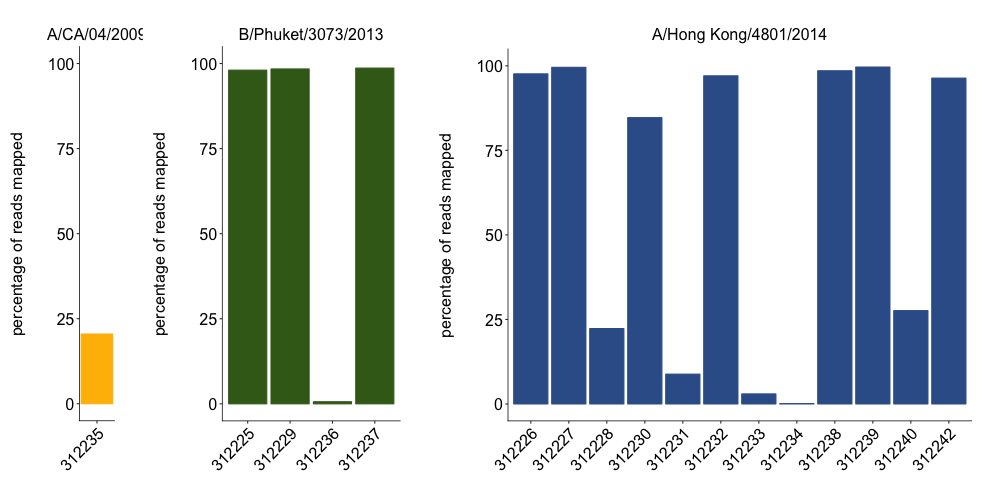

In [309]:
%%R -w 1000 -h 500 -u px -i df4_capture  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

# switch this out to run on rtpcr or capture data
df4 = df4_capture

CA04 <- df4[df4$max == "A/California/04/2009",]
HK <- df4[df4$max == "A/HongKong/4801/2014",]
PHK <- df4[df4$max == "B/Phuket/3073/2013",]

CA04.plot <- ggplot(data=CA04, aes(x=index, y=total_percent_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    facet_wrap(~max, ncol = 2, scales="free")+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("A/CA/04/2009") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_continuous(limits=c(0,100))+
    scale_color_manual(values=c('#FFBB00'), guide=FALSE)+
    scale_fill_manual(values=c('#FFBB00'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

PHK.plot <- ggplot(data=PHK, aes(x=index, y=total_percent_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    facet_wrap(~max, ncol = 2, scales="free")+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("B/Phuket/3073/2013") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_continuous(limits=c(0,100))+
    scale_color_manual(values=c('#3F681C'), guide=FALSE)+
    scale_fill_manual(values=c('#3F681C'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

HK.plot <- ggplot(data=HK, aes(x=index, y=total_percent_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("A/Hong Kong/4801/2014") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_continuous(limits=c(0,100))+    
    scale_color_manual(values=c('#375E97'), guide=FALSE)+
    scale_fill_manual(values=c('#375E97'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p2 <- grid.arrange(CA04.plot, PHK.plot, HK.plot, ncol=3, widths=c(1,2,4))
#p2 <- grid.arrange(top.plot, bottom.plot, left = textGrob("total percentage of reads that mapped", rot = 90, vjust = 1, gp = gpar(fontsize=16)))

ggsave("2019-01-31-seattle-flu-seq-twist-mapping-proportion.pdf", p2, width = 15, height = 5, device=pdf, path="/Users/lmoncla/src/seattle-flu-seq")


### Plot the total number of reads that mapped 

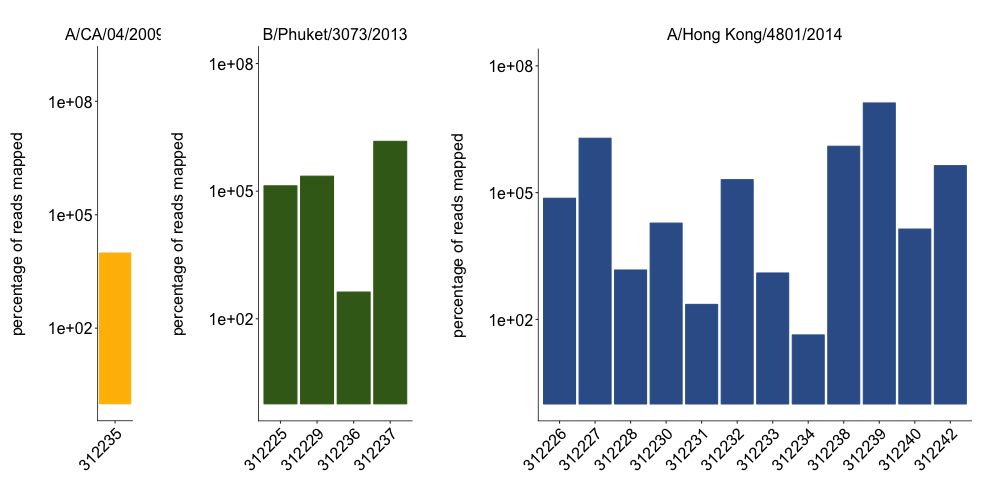

In [358]:
%%R -w 1000 -h 500 -u px -i df4_capture  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

# switch this out to run on rtpcr or capture data
df4 = df4_capture

CA04 <- df4[df4$max == "A/California/04/2009",]
HK <- df4[df4$max == "A/HongKong/4801/2014",]
PHK <- df4[df4$max == "B/Phuket/3073/2013",]

CA04.plot <- ggplot(data=CA04, aes(x=index, y=total_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    facet_wrap(~max, ncol = 2, scales="free")+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("A/CA/04/2009") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_log10(limits=c(1,1000000000))+
    scale_color_manual(values=c('#FFBB00'), guide=FALSE)+
    scale_fill_manual(values=c('#FFBB00'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

PHK.plot <- ggplot(data=PHK, aes(x=index, y=total_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    facet_wrap(~max, ncol = 2, scales="free")+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("B/Phuket/3073/2013") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_log10(limits=c(1,100000000))+
    scale_color_manual(values=c('#3F681C'), guide=FALSE)+
    scale_fill_manual(values=c('#3F681C'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

HK.plot <- ggplot(data=HK, aes(x=index, y=total_aligned, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    labs(x=NULL, y="percentage of reads mapped")+
    ggtitle("A/Hong Kong/4801/2014") + 
    theme(plot.title = element_text(size=16, hjust=0.5))+
    scale_y_log10(limits=c(1,100000000))+   
    scale_color_manual(values=c('#375E97'), guide=FALSE)+
    scale_fill_manual(values=c('#375E97'), guide=FALSE)+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, angle=45, hjust=1, vjust=1))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p3 <- grid.arrange(CA04.plot, PHK.plot, HK.plot, ncol=3, widths=c(1.15,2,4))

ggsave("2019-01-31-seattle-flu-seq-twist-mapping-number.pdf", p3, width = 15, height = 5, device=pdf, path="/Users/lmoncla/src/seattle-flu-seq")

# Plot proportion of genome covered by >50x and 100x

In [316]:
# here is the dictionary I made for each sample with its reference sequence with the max reads mapped to it 
#top_reference_sequence_match_capture

In [317]:
# dictionaries with proportion of genome covered by 50x and 100x 
ca04_capture_dict3 = calculate_percent_genome_coverage('ca04_capture')
hk4801_capture_dict3 = calculate_percent_genome_coverage('hk4801_capture')
BMich_capture_dict3 = calculate_percent_genome_coverage('BMich_capture')
BPhuk_capture_dict3 = calculate_percent_genome_coverage('BPhuk_capture')

In [318]:
#ca04_capture_dict3

In [319]:
# go through and select out on the mapping results for the highest mapping reference sequence 
percent_genome_coverage_capture = {}

reference_dict_capture = {'A/California/04/2009':ca04_capture_dict3, 'A/HongKong/4801/2014':hk4801_capture_dict3, 'B/Michigan/49/2017':BMich_capture_dict3, 'B/Phuket/3073/2013':BPhuk_capture_dict3}

for sample in top_reference_sequence_match_capture:
    max_hit = top_reference_sequence_match_capture[sample]['max']
    dict_to_retrieve = reference_dict_capture[max_hit]
    
    percent_genome_coverage_capture[sample] = {}
    
    proportion_over_50x = dict_to_retrieve[sample]["percent_genome_over_50x"]
    proportion_over_100x = dict_to_retrieve[sample]["percent_genome_over_100x"]
        
    percent_genome_coverage_capture[sample]["proportion_over_50x"] = proportion_over_50x
    percent_genome_coverage_capture[sample]["proportion_over_100x"] = proportion_over_100x
    percent_genome_coverage_capture[sample]["top_reference_hit"] = max_hit

In [320]:
#print(percent_genome_coverage_capture)

In [321]:
# convert to dataframe to plot
percent_genome_coverage_df_capture = pd.DataFrame.from_dict(percent_genome_coverage_capture, orient='index')
percent_genome_coverage_df_capture.reset_index(inplace=True)
percent_genome_coverage_df_capture.head()

,index,proportion_over_50x,proportion_over_100x,top_reference_hit
0,312225,0.992804,0.991887,B/Phuket/3073/2013
1,312226,0.986713,0.970754,A/HongKong/4801/2014
2,312227,0.996660,0.996660,A/HongKong/4801/2014
3,312228,0.012916,0.000000,A/HongKong/4801/2014
4,312229,0.994427,0.988148,B/Phuket/3073/2013


In [361]:
# output a few stats for capture data
number_over_50 = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] >= 0.5].count()
number_over_80 = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] >= 0.8].count()
number_100 = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] == 1.0].count()
number_0 = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] == 0].count()

print("over 50:", number_over_50)
print("over 80:", number_over_80)
print("number 100, 0", number_100, number_0)

over 50: index                   11
proportion_over_50x     11
proportion_over_100x    11
top_reference_hit       11
dtype: int64
over 80: index                   11
proportion_over_50x     11
proportion_over_100x    11
top_reference_hit       11
dtype: int64
number 100, 0 index                   0
proportion_over_50x     0
proportion_over_100x    0
top_reference_hit       0
dtype: int64 index                   3
proportion_over_50x     3
proportion_over_100x    3
top_reference_hit       3
dtype: int64


In [323]:
# melt
percent_genome_coverage_df_melt_capture = percent_genome_coverage_df_capture.melt(id_vars=['top_reference_hit', 'index'])
percent_genome_coverage_df_melt_capture.head()

,top_reference_hit,index,variable,value
0,B/Phuket/3073/2013,312225,proportion_over_50x,0.992804
1,A/HongKong/4801/2014,312226,proportion_over_50x,0.986713
2,A/HongKong/4801/2014,312227,proportion_over_50x,0.996660
3,A/HongKong/4801/2014,312228,proportion_over_50x,0.012916
4,B/Phuket/3073/2013,312229,proportion_over_50x,0.994427


In [324]:
# output a list of the samples that have >= 80% genome coverage (over 50x)
full_genomes_capture = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] >= 0.8]
full_genomes_capture = full_genomes_capture['index'].tolist()

In [359]:
%%R -w 1000 -h 500 -u px -i percent_genome_coverage_df_capture  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)
#, color=variable, fill=variable
p4 <- ggplot(data=percent_genome_coverage_df_capture, aes(x=proportion_over_50x)) + 
    geom_histogram(binwidth=0.1,boundary = 0.1)+
    labs(x="proportion of genome with at least 50x coverage", y="number of samples")+
    ggtitle("Seattle flu: twist panel 2019-01-31") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_x_continuous(breaks=seq(0,0.9,0.1))+
    #scale_y_continuous(limits=c(0,60), breaks=seq(0,60,10))+    
    scale_y_continuous(limits=c(0,10), breaks=seq(0,10,2))+
    scale_color_manual(values=c('#FFBB00','#3F681C','#3F681C'))+
    scale_fill_manual(values=c('#FFBB00','#3F681C','#3F681C'))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_blank())+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16, vjust=0.5, angle=45))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p4
ggsave("2019-01-31-proportion-genome-covered-twist.pdf", p4, width = 7, height = 4, device=pdf, path="/Users/lmoncla/src/seattle-flu-seq")

# Plot mean coverage per gene

In [326]:
# get the mean coverage per gene
ca04_capture_dict2 = get_mean_coverage_per_gene('ca04_capture')
hk4801_capture_dict2 = get_mean_coverage_per_gene('hk4801_capture')
BMich_capture_dict2 = get_mean_coverage_per_gene('BMich_capture')
BPhuk_capture_dict2 = get_mean_coverage_per_gene('BPhuk_capture')

In [327]:
# run to output the top reference sequence match for each sample in the dataset
captures = [ca04_capture_dict, hk4801_capture_dict, BMich_capture_dict, BPhuk_capture_dict]

top_reference_sequence_match_capture, top_reference_sequence_match_capture_df, capture_df = output_top_reference_sequence(captures)

In [328]:
top_reference_sequence_match_capture

{'312225': {'max': 'B/Phuket/3073/2013'},
 '312226': {'max': 'A/HongKong/4801/2014'},
 '312227': {'max': 'A/HongKong/4801/2014'},
 '312228': {'max': 'A/HongKong/4801/2014'},
 '312229': {'max': 'B/Phuket/3073/2013'},
 '312230': {'max': 'A/HongKong/4801/2014'},
 '312231': {'max': 'A/HongKong/4801/2014'},
 '312232': {'max': 'A/HongKong/4801/2014'},
 '312233': {'max': 'A/HongKong/4801/2014'},
 '312234': {'max': 'A/HongKong/4801/2014'},
 '312235': {'max': 'A/California/04/2009'},
 '312236': {'max': 'B/Phuket/3073/2013'},
 '312237': {'max': 'B/Phuket/3073/2013'},
 '312238': {'max': 'A/HongKong/4801/2014'},
 '312239': {'max': 'A/HongKong/4801/2014'},
 '312240': {'max': 'A/HongKong/4801/2014'},
 '312242': {'max': 'A/HongKong/4801/2014'}}

In [329]:
# go through and select out on the mapping results for the highest mapping reference sequence 
per_gene_coverage_capture = {}

reference_dict_capture = {'A/California/04/2009':ca04_capture_dict2, 'A/HongKong/4801/2014':hk4801_capture_dict2, 'B/Michigan/49/2017':BMich_capture_dict2, 'B/Phuket/3073/2013':BPhuk_capture_dict2}

for sample in top_reference_sequence_match_capture:
    max_hit = top_reference_sequence_match_capture[sample]['max']
    dict_to_retrieve = reference_dict_capture[max_hit]
    per_gene_coverage_capture[sample] = dict_to_retrieve[sample]
    per_gene_coverage_capture[sample]["top_reference_hit"] = max_hit

In [330]:
len(per_gene_coverage_capture)

17

In [343]:
# convert to dataframes to plot 
per_gene_coverage_capture_df = pd.DataFrame.from_dict(per_gene_coverage_capture, orient='index')
per_gene_coverage_capture_df.reset_index(inplace=True)
per_gene_coverage_capture_df = pd.melt(per_gene_coverage_capture_df, id_vars=('method','reference_sequence','index'), value_vars=('NP','PB2','PB1','PA','HA','NA','MP','M2','M1','NS','NS1','NS2'))
per_gene_coverage_capture_df.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,method,reference_sequence,index,variable,value
0,capture,B/Phuket/3073/2013,312225,NP,2565.16
1,capture,A/HongKong/4801/2014,312226,NP,715.27
2,capture,A/HongKong/4801/2014,312227,NP,28885.74
3,capture,A/HongKong/4801/2014,312228,NP,17.07
4,capture,B/Phuket/3073/2013,312229,NP,3285.05


In [344]:
per_gene_coverage_capture_df.head()

,method,reference_sequence,index,variable,value
0,capture,B/Phuket/3073/2013,312225,NP,2565.16
1,capture,A/HongKong/4801/2014,312226,NP,715.27
2,capture,A/HongKong/4801/2014,312227,NP,28885.74
3,capture,A/HongKong/4801/2014,312228,NP,17.07
4,capture,B/Phuket/3073/2013,312229,NP,3285.05


In [345]:
# get rid of NS1 and NS2 rows for A/HongKong and B/Phuket samples 
# Get names of indexes for which column Age has value 30
indexNames = per_gene_coverage_capture_df[(per_gene_coverage_capture_df['reference_sequence'] == "A/HongKong/4801/2014") & ((per_gene_coverage_capture_df['variable'] == "NS1")|(per_gene_coverage_capture_df['variable'] == "NS2")|(per_gene_coverage_capture_df['variable'] == "M1")|(per_gene_coverage_capture_df['variable'] == "M2"))].index
indexNames2 = per_gene_coverage_capture_df[(per_gene_coverage_capture_df['reference_sequence'] == "B/Phuket/3073/2013") & ((per_gene_coverage_capture_df['variable'] == "NS1")|(per_gene_coverage_capture_df['variable'] == "NS2")|(per_gene_coverage_capture_df['variable'] == "M1")|(per_gene_coverage_capture_df['variable'] == "M2"))].index
indexNames3 = per_gene_coverage_capture_df[(per_gene_coverage_capture_df['reference_sequence'] == "A/California/04/2009") & ((per_gene_coverage_capture_df['variable'] == "NS")|(per_gene_coverage_capture_df['variable'] == "MP"))].index

# Delete these row indexes from dataFrame
per_gene_coverage_capture_df.drop(indexNames , inplace=True)
per_gene_coverage_capture_df.drop(indexNames2 , inplace=True)
per_gene_coverage_capture_df.drop(indexNames3 , inplace=True)
per_gene_coverage_capture_df.head()

,method,reference_sequence,index,variable,value
0,capture,B/Phuket/3073/2013,312225,NP,2565.16
1,capture,A/HongKong/4801/2014,312226,NP,715.27
2,capture,A/HongKong/4801/2014,312227,NP,28885.74
3,capture,A/HongKong/4801/2014,312228,NP,17.07
4,capture,B/Phuket/3073/2013,312229,NP,3285.05


In [346]:
# get rid of rows with NAs in them for plotting
per_gene_coverage_capture_df = per_gene_coverage_capture_df.fillna(0)

In [357]:
%%R -w 1000 -h 500 -u px -i per_gene_coverage_capture_df  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)

df = per_gene_coverage_capture_df
df$gene = factor(df$variable, levels=c('PB2','PB1','PA','HA','NP','NA','MP','M1','M2','NS','NS1','NS2'))

p5 <- ggplot(data=df, aes(x=gene, y=value, color=reference_sequence, fill=reference_sequence)) + 
    geom_col()+
    facet_wrap(~index, scales="free")+
    labs(x='gene', y='coverage')+
    scale_y_log10(limits=c(1,1000000))+
    ggtitle("Seattle flu data: twist 2019-01-31") + 
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_color_manual(values=c('#FFBB00','#375E97','#3F681C'))+
    scale_fill_manual(values=c('#FFBB00','#375E97','#3F681C'))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-8))+
    theme(axis.text=element_text(size=12, colour="black"))+
    theme(axis.text.x=element_text(size=12, angle=90, hjust=1, vjust=0.5))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_text(size=16, face="plain"))+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

p5
ggsave("2019-01-31-seattle-flu-seq-twist-coverage_per_gene.pdf", p5, width = 20, height = 10, device=pdf, path="/Users/lmoncla/src/seattle-flu-seq")


In [271]:
# output a list of the samples that have >= 80% genome coverage (over 50x)
full_genomes_capture = percent_genome_coverage_df_capture[percent_genome_coverage_df_capture['proportion_over_50x'] >= 0.8]
full_genomes_capture = full_genomes_capture['index'].tolist()

In [ ]:
# subset dataframes down to include only samples with >= 80% of the genome with >= 50x reads
per_gene_coverage_capture_full_genomes_df = per_gene_coverage_capture_df.loc[per_gene_coverage_capture_df['index'].isin(full_genomes_capture)]

In [ ]:
# get rid of rows with NAs in them for plotting
per_gene_coverage_capture_full_genomes_df = per_gene_coverage_capture_full_genomes_df.dropna(axis=0, how='any')

In [189]:
per_gene_coverage_capture_full_genomes_df

,method,reference_sequence,index,variable,value
1,capture,A/HongKong/4801/2014,312226,NP,715.27
2,capture,A/HongKong/4801/2014,312227,NP,28885.74
5,capture,A/HongKong/4801/2014,312230,NP,197.34
7,capture,A/HongKong/4801/2014,312232,NP,1898.74
13,capture,A/HongKong/4801/2014,312238,NP,13789.79
14,capture,A/HongKong/4801/2014,312239,NP,195035.69
15,capture,A/HongKong/4801/2014,312240,NP,130.45
16,capture,A/HongKong/4801/2014,312242,NP,5357.59
18,capture,A/HongKong/4801/2014,312226,PB2,780.55
19,capture,A/HongKong/4801/2014,312227,PB2,26182.45
